In [22]:
# Import required modules.
import re
import gzip
import time
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from scipy import stats
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## Exploratory Data Analysis

In [169]:
# Read the data into de.
de = pd.read_csv('../data/MIT-BIH_Arrhythmia_Database.csv')

In [3]:
# Show the head of de.
de.head()

,record,type,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,...,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
0,101,N,76,313.0,0.074347,-0.160548,1.036401,-0.285662,-0.026824,41,...,0.025930,2,18,22,2,0.025930,0.025930,0.025930,0.025436,0.025436
1,101,N,313,315.0,-0.052079,-0.264784,0.886597,-0.366298,-0.059710,21,...,-0.042009,26,27,62,9,-0.042009,-0.029498,0.005012,0.030892,0.002986
2,101,N,315,321.0,-0.062151,-0.296983,0.991859,-0.410306,-0.065686,22,...,0.009528,3,8,12,1,0.009528,0.009528,0.008786,0.008786,0.008368
3,101,N,321,336.0,-0.063322,-0.281386,1.034903,-0.403880,-0.071750,22,...,-0.020536,6,9,16,1,-0.020536,-0.020257,-0.018965,-0.016968,-0.014555
4,101,N,336,344.0,-0.062915,1.046914,1.046408,1.046408,-0.074639,11,...,0.016053,16,5,31,10,0.016053,0.006742,0.002782,-0.007798,-0.051155


In [4]:
# Show the shape of de.
de.shape

(100689, 34)

In [5]:
# Select rows with column 'type' equal to 'VEB', 'SVEB', 'F' or 'Q'.
dq = de[(de.type == 'VEB') | (de.type == 'SVEB') | (de.type == 'F') | (de.type == 'Q')]

In [6]:
# Show the shape of df_ari.
dq.shape

(10606, 34)

In [18]:
# Save df_ari to the data folder.
dq.to_csv('~/ML_Zoomcamp_2024_Project_Mid/data/MIT-BIH_VEB_SVEB_F_Q.csv')

In [7]:
# Check for duplicates in de.
de[de.duplicated()].sum()

record              0
type                0
0_pre-RR            0
0_post-RR         0.0
0_pPeak           0.0
0_tPeak           0.0
0_rPeak           0.0
0_sPeak           0.0
0_qPeak           0.0
0_qrs_interval      0
0_pq_interval       0
0_qt_interval       0
0_st_interval       0
0_qrs_morph0      0.0
0_qrs_morph1      0.0
0_qrs_morph2      0.0
0_qrs_morph3      0.0
0_qrs_morph4      0.0
1_pre-RR            0
1_post-RR         0.0
1_pPeak           0.0
1_tPeak           0.0
1_rPeak           0.0
1_sPeak           0.0
1_qPeak           0.0
1_qrs_interval      0
1_pq_interval       0
1_qt_interval       0
1_st_interval       0
1_qrs_morph0      0.0
1_qrs_morph1      0.0
1_qrs_morph2      0.0
1_qrs_morph3      0.0
1_qrs_morph4      0.0
dtype: object

In [8]:
# Check for missing values in de.
de.isnull().sum()

record            0
type              0
0_pre-RR          0
0_post-RR         0
0_pPeak           0
0_tPeak           0
0_rPeak           0
0_sPeak           0
0_qPeak           0
0_qrs_interval    0
0_pq_interval     0
0_qt_interval     0
0_st_interval     0
0_qrs_morph0      0
0_qrs_morph1      0
0_qrs_morph2      0
0_qrs_morph3      0
0_qrs_morph4      0
1_pre-RR          0
1_post-RR         0
1_pPeak           0
1_tPeak           0
1_rPeak           0
1_sPeak           0
1_qPeak           0
1_qrs_interval    0
1_pq_interval     0
1_qt_interval     0
1_st_interval     0
1_qrs_morph0      0
1_qrs_morph1      0
1_qrs_morph2      0
1_qrs_morph3      0
1_qrs_morph4      0
dtype: int64

In [9]:
# Get the statistics of de.
dt = de.describe().round()

In [10]:
# Show statistics of the first 16 columns.
dt.iloc[:, :16]

,record,0_pre-RR,0_post-RR,0_pPeak,0_tPeak,0_rPeak,0_sPeak,0_qPeak,0_qrs_interval,0_pq_interval,0_qt_interval,0_st_interval,0_qrs_morph0,0_qrs_morph1,0_qrs_morph2,0_qrs_morph3
count,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0
mean,174.0,279.0,279.0,0.0,0.0,1.0,-0.0,-0.0,28.0,11.0,60.0,20.0,-0.0,0.0,0.0,1.0
std,52.0,82.0,81.0,0.0,1.0,1.0,1.0,0.0,15.0,9.0,40.0,30.0,0.0,0.0,1.0,1.0
min,100.0,11.0,6.0,-3.0,-2.0,-2.0,-4.0,-4.0,0.0,1.0,5.0,1.0,-4.0,-3.0,-3.0,-3.0
25%,115.0,230.0,230.0,-0.0,-0.0,1.0,-1.0,-0.0,18.0,5.0,33.0,1.0,-0.0,-0.0,-0.0,0.0
50%,203.0,267.0,266.0,0.0,0.0,1.0,-1.0,-0.0,27.0,7.0,46.0,8.0,-0.0,-0.0,0.0,0.0
75%,219.0,324.0,322.0,0.0,1.0,1.0,1.0,-0.0,38.0,16.0,75.0,23.0,-0.0,0.0,1.0,1.0
max,234.0,2114.0,2114.0,4.0,4.0,4.0,4.0,3.0,170.0,150.0,334.0,141.0,3.0,3.0,3.0,3.0


In [11]:
# Show statistics of the last 17 columns.
dt.iloc[:, 17:]

,1_pre-RR,1_post-RR,1_pPeak,1_tPeak,1_rPeak,1_sPeak,1_qPeak,1_qrs_interval,1_pq_interval,1_qt_interval,1_st_interval,1_qrs_morph0,1_qrs_morph1,1_qrs_morph2,1_qrs_morph3,1_qrs_morph4
count,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0,100689.0
mean,279.0,279.0,0.0,0.0,-0.0,-0.0,-0.0,11.0,10.0,36.0,14.0,-0.0,-0.0,-0.0,-0.0,-0.0
std,82.0,81.0,0.0,0.0,1.0,1.0,0.0,12.0,9.0,17.0,9.0,0.0,0.0,1.0,1.0,1.0
min,11.0,6.0,-2.0,-2.0,-4.0,-6.0,-5.0,0.0,1.0,5.0,1.0,-5.0,-4.0,-4.0,-4.0,-5.0
25%,230.0,230.0,-0.0,0.0,-0.0,-1.0,-1.0,3.0,5.0,25.0,10.0,-1.0,-1.0,-1.0,-1.0,-1.0
50%,267.0,266.0,0.0,0.0,-0.0,-0.0,-0.0,7.0,8.0,33.0,12.0,-0.0,-0.0,-0.0,-0.0,-0.0
75%,324.0,322.0,0.0,1.0,0.0,-0.0,-0.0,18.0,13.0,45.0,17.0,-0.0,-0.0,0.0,0.0,-0.0
max,2114.0,2114.0,5.0,7.0,4.0,3.0,4.0,260.0,185.0,412.0,215.0,4.0,4.0,3.0,4.0,3.0


In [12]:
# Check the value counts of the target.
de.type.value_counts()

type
N       90083
VEB      7009
SVEB     2779
F         803
Q          15
Name: count, dtype: int64

In [170]:
# Transform multi-class labels into binary-class (1 and 0).
de['type'] = de.type.map({'N': 0, 'VEB': 1, 'SVEB': 1, 'F': 1, 'Q': 1})

In [14]:
# Check the value counts of the target.
de.type.value_counts()

type
0    90083
1    10606
Name: count, dtype: int64

In [171]:
#  Create a function to split the data before Applying SMOTE.
def split_smote(df):
    
    df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=22)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=22)

    df_full_train = df_full_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)

    y_full_train = df_full_train['type'].values
    y_test = df_test.type.values
    y_train = df_train.type.values
    y_val = df_val.type.values

    del df_full_train['type']
    del df_test['type']
    del df_train['type']
    del df_val['type']

    dv = DictVectorizer(sparse=False)

    full_train_dicts = df_full_train.to_dict(orient='records')
    test_dicts = df_test.to_dict(orient='records')
    train_dicts = df_train.to_dict(orient='records')
    val_dicts = df_val.to_dict(orient='records')
    
    X_full_train = dv.fit_transform(full_train_dicts)
    X_test = dv.transform(test_dicts)    
    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    return  X_full_train, X_test, X_train, X_val, y_full_train, y_test, y_train, y_val, dv

In [174]:
# Create function to get the score before Applying SMOTE.
def score_smote(alg):
    _, _, X_train, X_val, _, _, y_train, y_val, dv = split_smote(df)
    model = alg.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    score = round(roc_auc_score(y_val, y_pred), 4)

    return score, y_val, y_pred, dv, model

## First Training

### Logistic Regression Algorithm

In [175]:
# Calculate the ROC AUC score.
df = de.copy()
alg_lra = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=22)
score_lra, y_val, y_pred, dv, model_lra = score_smote(alg_lra)
print(f'score_lra = {round(score_lra, 4)}')

score_lra = 0.955


In [176]:
# Define the models folder.
mdf = '/home/awsl/ML_Zoomcamp_2024_Project_Mid/models/'

In [178]:
# Save the model to the medel folder.
with open(mdf + 'model_lra_1.bin', 'wb') as f_out: 
    pickle.dump((dv, score_lra), f_out)

### Random Forest Classifier

In [ ]:
# Calculate the ROC AUC score.
df = de.copy()
alg_rfc = RandomForestClassifier(n_estimators=100, random_state=22, n_jobs=-1)
score_rfc, y_val, y_pred, dv, model_rfc = score_smote(alg_rfc)
print(f'score_rfc = {round(score_rfc, 4)}')

In [ ]:
# Save the model to the model folder.
with open(mdf + 'model_rfc_1.bin', 'wb') as f_out: 
    pickle.dump((dv, model_rfc), f_out)

### Gradient Boosting Classifier

In [ ]:
# Calculate the ROC AUC score.
df = de.copy()
alg_gbc = GradientBoostingClassifier(n_estimators=100, random_state=22)
score_gbc, y_val, y_pred, dv, model_gbc = score_smote(alg_gbc)
print(f'score_gbc = {round(score_gbc, 4)}')

In [ ]:
# Save the model to the model folder.
with open(mdf + 'model_gbc_1.bin', 'wb') as f_out: 
    pickle.dump((dv, model_gbc), f_out)

### XGB Classifier

In [ ]:
# Define a function to create dtrain and dval.
def dicts_smote(df):
    _, _, X_train, X_val, _, _, y_train, y_val, dv = split_smote(df)

    features = dv.feature_names_
    regex = re.compile(r"<", re.IGNORECASE)
    features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
    dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

    return dtrain, dval, y_val, dv

In [ ]:
# Create function to get xgb score.
def score_xsmote(xgb_params):
    dtrain, dval, y_val, dv = get_dicts(df)
    model = xgb.train(xgb_params, dtrain, num_boost_round=10)
    y_pred = model.predict(dval)
    score = roc_auc_score(y_val, y_pred)

    return score, y_val, y_pred, dv, model

In [ ]:
# Calculate the ROC AUC score.
df = de.copy()

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

score_xgb, y_val, y_pred, dv, model_xgb = score_xsmote(xgb_params)
print(f'score_xgb = {round(score_xgb, 4)}')

In [ ]:
# Save the model to the model folder.
with open(mdf + 'model_xgb_1.bin', 'wb') as f_out: 
    pickle.dump((dv, model_xgb), f_out)

In [15]:
#  Create a function to split the data.
def split_data(df):
    
    df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=22)
    df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=22)

    df_full_train = df_full_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)

    y_full_train = df_full_train['type'].values
    y_test = df_test.type.values
    y_train = df_train.type.values
    y_val = df_val.type.values

    del df_full_train['type']
    del df_test['type']
    del df_train['type']
    del df_val['type']

    sm = SMOTE(random_state=22)
    df_full_train_sm, y_full_train_sm = sm.fit_resample(df_full_train, y_full_train)
    df_train_sm, y_train_sm = sm.fit_resample(df_train, y_train)
    
    dv = DictVectorizer(sparse=False)

    full_train_dicts = df_full_train_sm.to_dict(orient='records')
    test_dicts = df_test.to_dict(orient='records')
    train_dicts = df_train_sm.to_dict(orient='records')
    val_dicts = df_val.to_dict(orient='records')
    
    X_full_train = dv.fit_transform(full_train_dicts)
    X_test = dv.transform(test_dicts)    
    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    return  X_full_train, X_test, X_train, X_val, y_full_train_sm, y_test, y_train_sm, y_val, dv

In [ ]:
# Create function to get the score.
def score_data(alg):
    _, _, X_train, X_val, _, _, y_train, y_val, _ = split_data(df)
    model = alg.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    score = round(roc_auc_score(y_val, y_pred), 4)

    return score, y_val, y_pred

## Second Training

### Logistic Regression Algorithm

In [17]:
# Calculate the ROC AUC score.
df = de.copy()
alg_lra = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=22)
score_lra, y_val, y_pred, dv, model_lra = score_data(alg_lra)
print(f'score_lra = {round(score_lra, 4)}')

score_lra = 0.9567


In [30]:
# Save the model to the medel folder.
with open(mdf + 'model_lra_2.bin', 'wb') as f_out: 
    pickle.dump((dv, score_lra), f_out)

### Random Forest Classifier

In [31]:
# Calculate the probability ROC AUC score.
df = de.copy()
alg_rfc = RandomForestClassifier(n_estimators=100, random_state=22, n_jobs=-1)
score_rfc, y_val, y_pred, dv, model_rfc = score_data(alg_rfc)
print(f'score_rfc = {round(score_rfc, 4)}')

score_rfc = 0.9989


In [32]:
# Save the model to the model folder.
with open(mdf + 'model_rfc_2.bin', 'wb') as f_out: 
    pickle.dump((dv, model_rfc), f_out)

### Gradient Boosting Classifier

In [33]:
# Calculate the probability ROC AUC score.
df = de.copy()
alg_gbc = GradientBoostingClassifier(n_estimators=100, random_state=22)
score_gbc, y_val, y_pred, dv, model_gbc = score_data(alg_gbc)
print(f'score_gbc = {round(score_gbc, 4)}')

score_gbc = 0.9934


In [34]:
# Save the model to the model folder.
with open(mdf + 'model_gbc_2.bin', 'wb') as f_out: 
    pickle.dump((dv, model_gbc), f_out)

### XGB Classifier

In [35]:
# Define a function to create dtrain and dval.
def dicts_data(df):
    _, _, X_train, X_val, _, _, y_train, y_val, dv = split_data(df)

    features = dv.feature_names_
    regex = re.compile(r"<", re.IGNORECASE)
    features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
    dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

    return dtrain, dval, y_val, dv

In [36]:
# Create function to get xgb score.
def score_xdata(xgb_params):
    dtrain, dval, y_val = dicts_data(df)
    model = xgb.train(xgb_params, dtrain, num_boost_round=10)
    y_pred = model.predict(dval)
    score = roc_auc_score(y_val, y_pred)

    return score, y_val, y_pred, dv, model

In [37]:
# Calculate the ROC AUC score.
df = de.copy()

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

score_xgb, y_val, y_pred, dv, model_xgb = score_xdata(xgb_params)
print(f'score_xgb = {round(score_xgb, 4)}')

score_xgb = 0.9955


In [38]:
# Save the model to the model folder.
with open(mdf + 'model_xgb_2.bin', 'wb') as f_out: 
    pickle.dump((dv, model_xgb), f_out)

In [39]:
# Define the columns for correlation.
cor_col = de.drop(columns='type').select_dtypes(include=np.number).columns.tolist()

In [40]:
# Check for correletion.
corr = de[cor_col].corr().round(2)

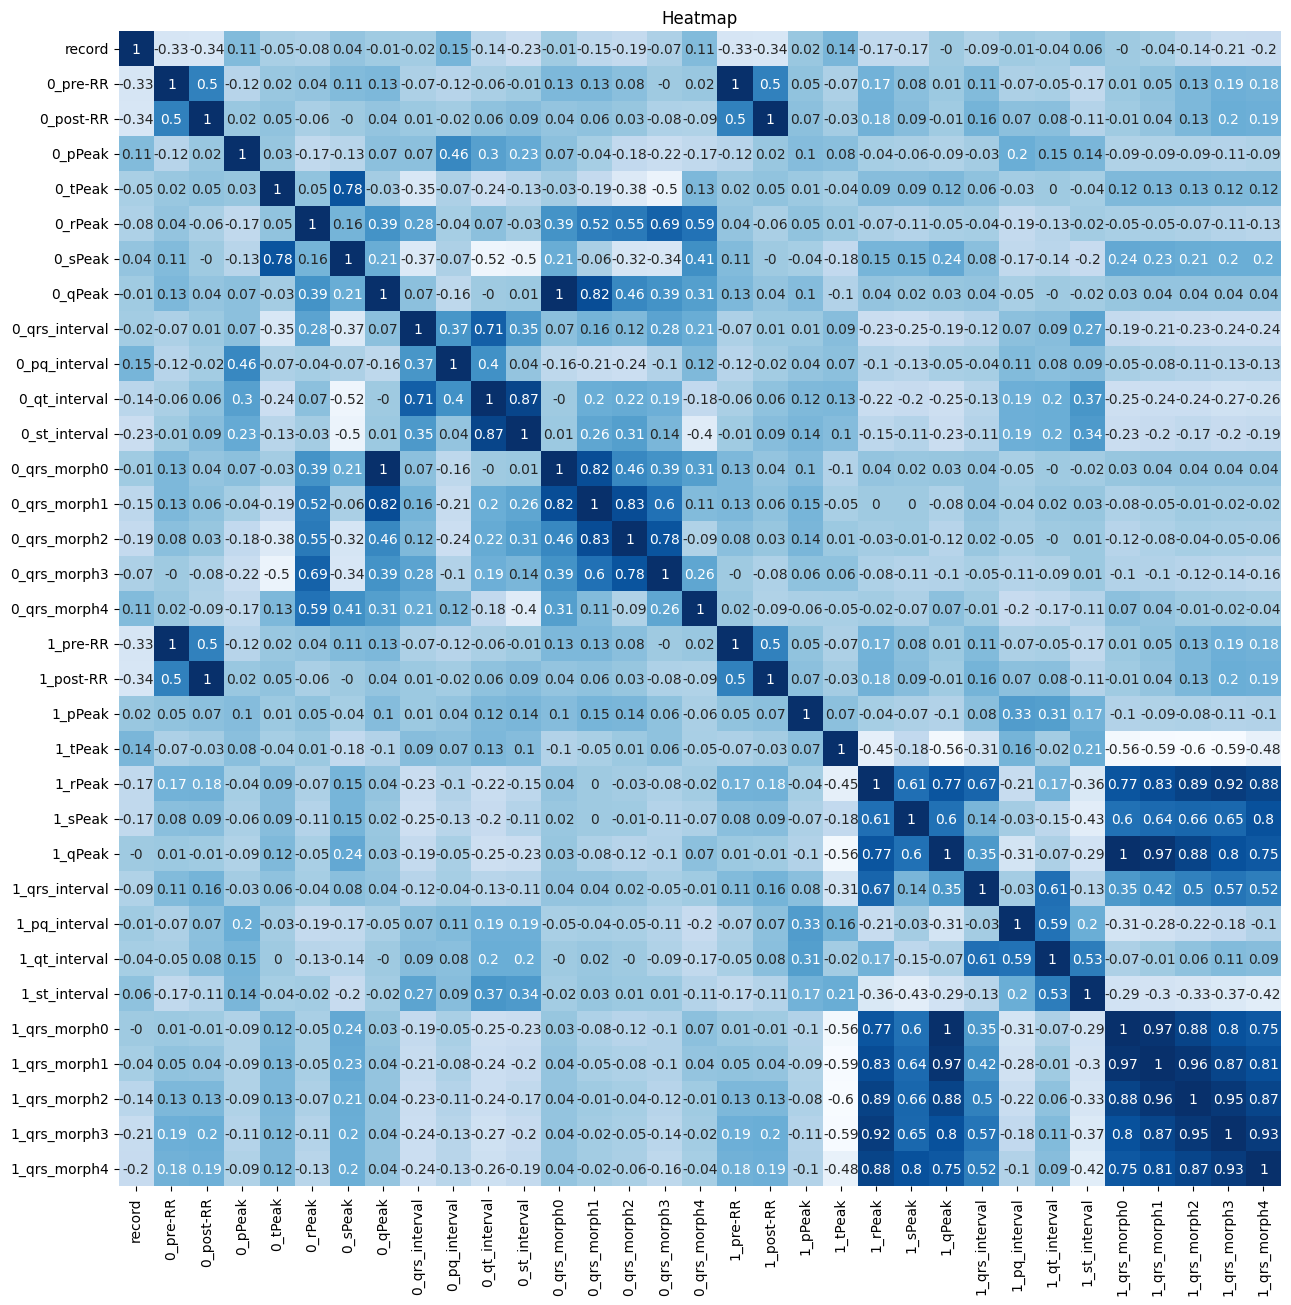

In [41]:
# Draw the correlation heatmap.
plt.figure(figsize=(15, 15))
sns.heatmap(corr, cmap='Blues', annot=True, cbar=False)
plt.title('Heatmap')
plt.show()

In [42]:
# List the highly correlated columns.
cor_rem = ['1_pre-RR', '1_post-RR', '0_qrs_morph0', '1_qrs_morph0', 
               '1_qrs_morph1', '1_qrs_morph2', '1_qrs_morph3', '1_qrs_morph4']

In [43]:
# Remove the highly correlated columns.
de = de.drop(columns=cor_rem)

In [44]:
# Show the shape of de.
de.shape

(100689, 26)

## Third Training

### Logistic Regression Algorithm

In [45]:
# Calculate the probability ROC AUC score.
df = de.copy()
alg_lra = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=22)
score_lra, y_val, y_pred, _ = score_data(alg_lra)
print(f'score_lra = {round(score_lra, 4)}')

score_lra = 0.9521


### Random Forest Classifier

In [46]:
# Calculate the probability ROC AUC score.
df = de.copy()
alg_rfc = RandomForestClassifier(n_estimators=100, random_state=22, n_jobs=-1)
score_rfc, y_val, y_pred, _ = score_data(alg_rfc)
print(f'score_rfc = {round(score_rfc, 4)}')

score_rfc = 0.9991


### Gradient Boosting Classifier

In [47]:
# Calculate the probability ROC AUC score.
df = de.copy()
alg_gbc = GradientBoostingClassifier(n_estimators=100, random_state=22)
score_gbc, y_val, y_pred, _ = score_data(alg_gbc)
print(f'score_gbc = {round(score_gbc, 4)}')

score_gbc = 0.9933


### XGB Classifier

In [48]:
# Calculate the ROC AUC score.
df = de.copy()

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

score_xgb, y_val, y_pred, _ = score_xdata(xgb_params)
print(f'score_xgb = {round(score_xgb, 4)}')

score_gbc = 0.9951


In [49]:
# Define numerical columns and split into two sets.
df = de.copy()
col_out = df.drop(columns="type").columns.to_list()
set_one = col_out[:13]
set_two = col_out[14:]

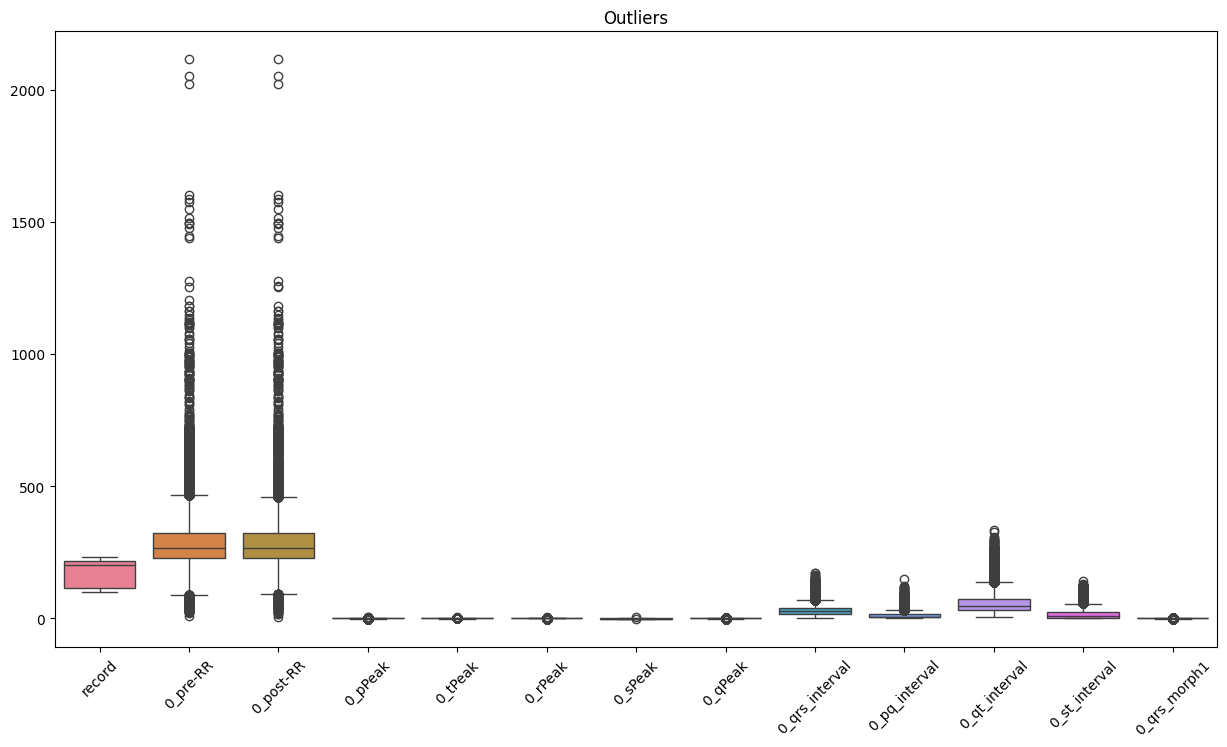

In [50]:
# Draw boxplot of the first set.
plt.figure(figsize=(15, 8))
the_plot = sns.boxplot(data=de[set_one])
plt.title('Outliers')
the_plot.set_xticklabels(the_plot.get_xticklabels(), rotation=45)
plt.show()

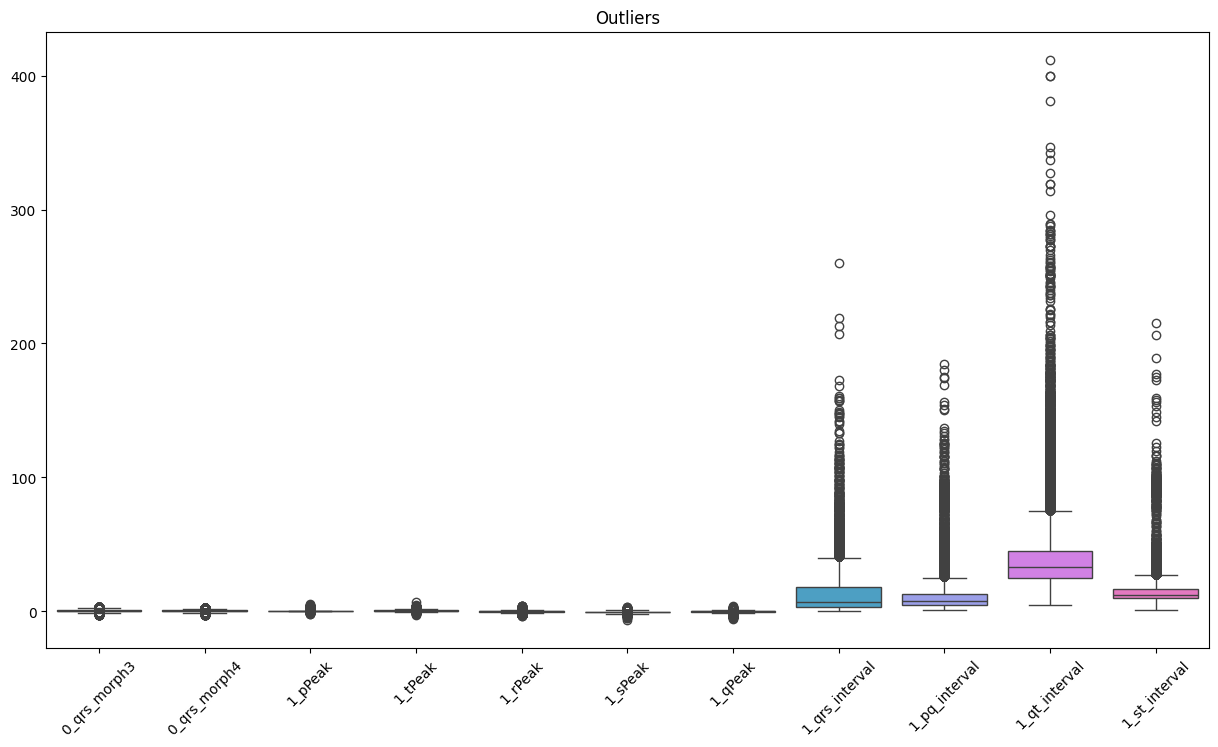

In [51]:
# Draw boxplot of the first set.
plt.figure(figsize=(15, 8))
the_plot = sns.boxplot(data=de[set_two])
plt.title('Outliers')
the_plot.set_xticklabels(the_plot.get_xticklabels(), rotation=45)
plt.show();

In [52]:
# Function to remove_outlier with quantile.
def remove_outlier(df_in, col_name):
    for col in col_name:
        q1 = df_in[col].quantile(0.1)
        q3 = df_in[col].quantile(0.9)
        iqr = q3 - q1
        lower = q1 - (1.5 * iqr)
        upper = q3 + (1.5 * iqr)
        df_out = df_in[~((df_in[col] < lower) | (df_in[col] > upper))]
        df_in = df_out
    
    return df_in

In [53]:
# Define the columns for outlier removal.
out_rem = ['0_pre-RR', '0_post-RR', '0_qrs_interval', '0_pq_interval', '0_qt_interval', 
           '0_st_interval', '1_qrs_interval', '1_pq_interval', '1_qt_interval', '1_st_interval']

In [54]:
# Remove outliers.
df = remove_outlier(df, out_rem)

In [55]:
# Show the shape of df.
df.shape

(98644, 26)

In [56]:
# Get percentage of data lost.
round(((100689 - 98644) * 100 / 100689), 2)

2.03

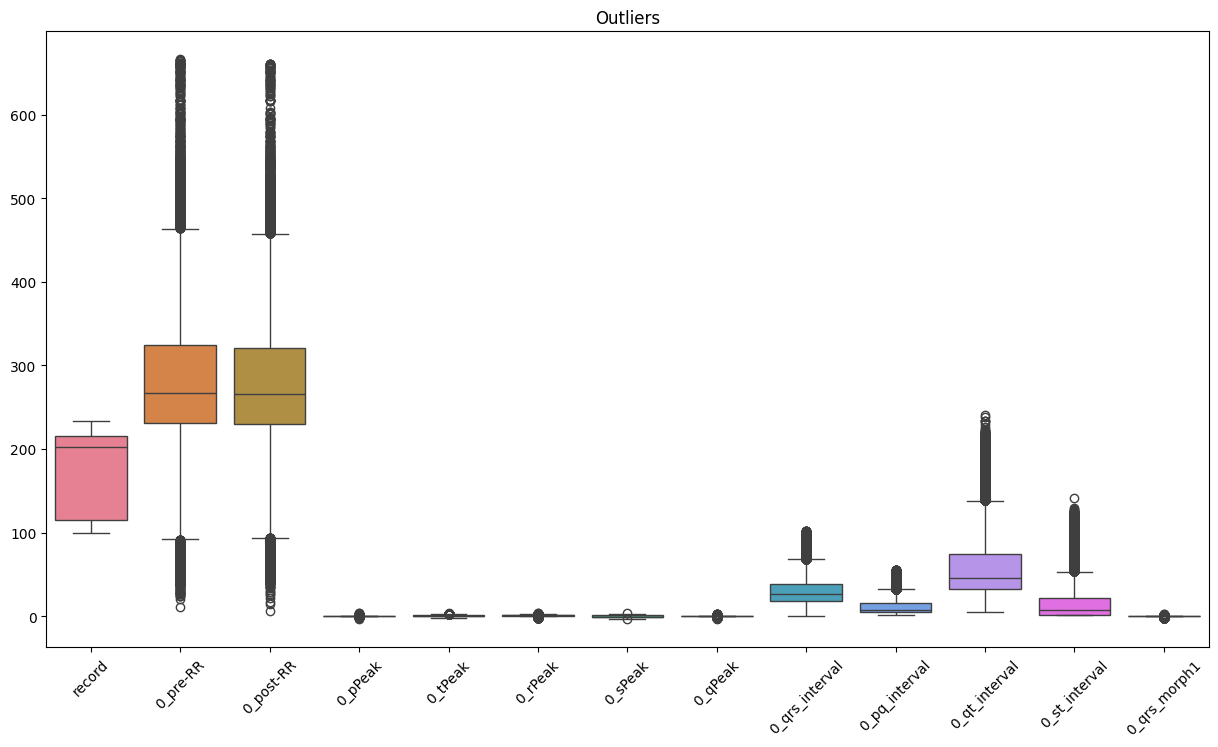

In [57]:
# Draw boxplot of the first set.
plt.figure(figsize=(15, 8))
the_plot = sns.boxplot(data=df[set_one])
plt.title('Outliers')
the_plot.set_xticklabels(the_plot.get_xticklabels(), rotation=45)
plt.show()

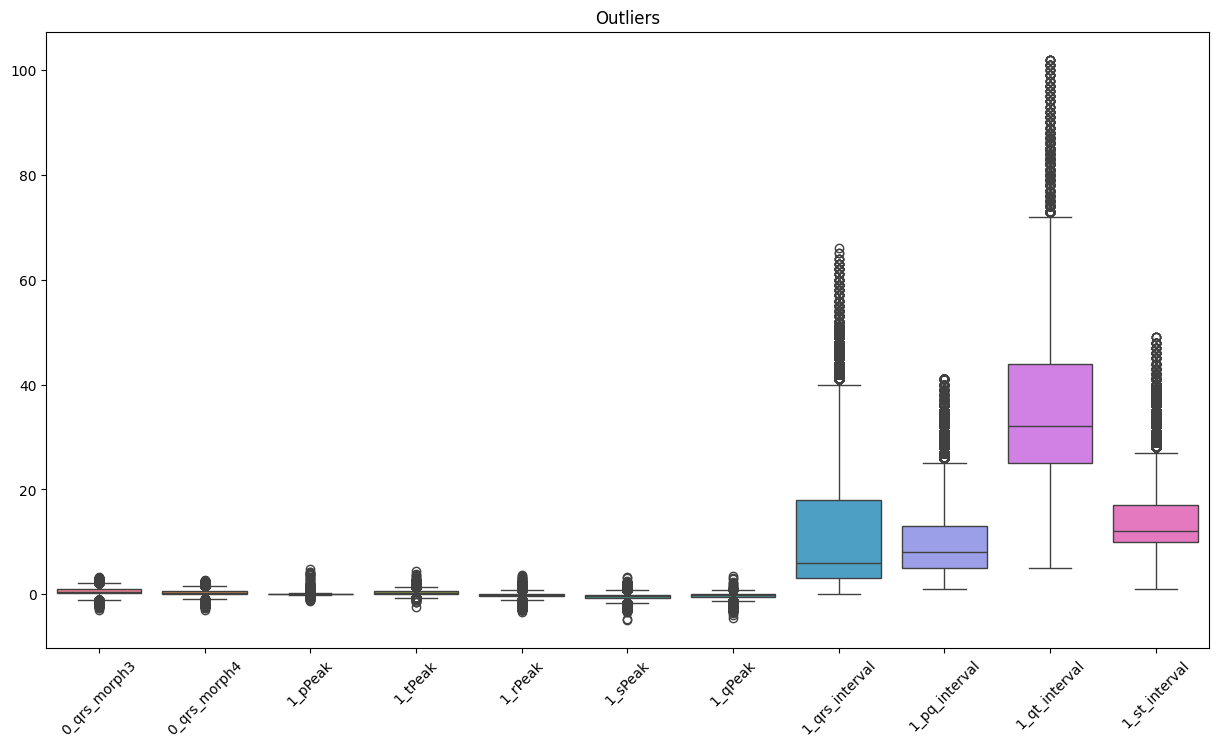

In [58]:
# Draw boxplot of the first set.
plt.figure(figsize=(15, 8))
the_plot = sns.boxplot(data=df[set_two])
plt.title('Outliers')
the_plot.set_xticklabels(the_plot.get_xticklabels(), rotation=45)
plt.show()

## Fourth Training

### Logistic Regression Algorithm

In [59]:
# Calculate the probability ROC AUC score.
df = de.copy()
alg_lra = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=22)
score_lra, y_val, y_pred, _, _ = score_data(alg_lra)
print(f'score_lra = {round(score_lra, 4)}')

score_lra = 0.9521


### Random Forest Classifier

In [60]:
# Calculate the probability ROC AUC score.
df = de.copy()
alg_rfc = RandomForestClassifier(n_estimators=100, random_state=22, n_jobs=-1)
score_rfc, y_val, y_pred, _, _ = score_data(alg_rfc)
print(f'score_rfc = {round(score_rfc, 4)}')

score_rfc = 0.9991


### Gradient Boosting Classifier

In [61]:
# Calculate the probability ROC AUC score.
df = de.copy()
alg_gbc = GradientBoostingClassifier(n_estimators=100, random_state=22)
score_gbc, y_val, y_pred, _, _ = score_data(alg_gbc)
print(f'score_gbc = {round(score_gbc, 4)}')

score_gbc = 0.9933


### XGB Classifier

In [62]:
# Calculate the ROC AUC score.
df = de.copy()

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

score_xgb, y_val, y_pred, _, _ = score_xdata(xgb_params)
print(f'score_xgb = {round(score_xgb, 4)}')

score_gbc = 0.9951


## Feature Importances

### Logistic Regression

In [63]:
# Split the data.
df = de.copy()
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=22)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=22)

In [64]:
# Apply the feature elimination technique.
original_score = score_lra
scores = pd.DataFrame(columns=['eliminated_feature', 'score_lr', 'difference'])
features = df_train.drop(columns='type').columns.to_list()

for feature in tqdm(features):
    subset = features.copy()
    subset.remove(feature)

    y_train = df_train.type.values
    y_val = df_val.type.values
    
    dv = DictVectorizer(sparse=False)
    train_dicts = df_train[subset].to_dict(orient='records')
    val_dicts = df_val[subset].to_dict(orient='records')

    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=22)
    model.fit(X_train, y_train)

    y_pred = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    
    scores.loc[len(scores)] = [feature, score, original_score - score]

  0%|          | 0/25 [00:00<?, ?it/s]

In [65]:
# Print the scores.
scores['difference'] = [abs(x) for x in scores['difference']]
scores.sort_values(by='difference', axis=0, ascending=False).iloc[:10,:]

,eliminated_feature,score_lr,difference
1,0_pre-RR,0.893880,0.058220
2,0_post-RR,0.934981,0.017119
0,record,0.939555,0.012545
5,0_rPeak,0.939842,0.012258
4,0_tPeak,0.945738,0.006362
17,1_tPeak,0.947769,0.004331
13,0_qrs_morph2,0.948274,0.003826
6,0_sPeak,0.948295,0.003805
18,1_rPeak,0.948452,0.003648
3,0_pPeak,0.948504,0.003596


### Random Forest Classifier

In [66]:
# Split the data.
df = de.copy()
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=22)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=22)

In [67]:
# Apply the feature elimination technique.
original_score = score_rfc
scores = pd.DataFrame(columns=['eliminated_feature', 'score_rf', 'difference'])
features = df_train.drop(columns='type').columns.to_list()

for feature in tqdm(features):
    subset = features.copy()
    subset.remove(feature)

    y_train = df_train.type.values
    y_val = df_val.type.values

    dv = DictVectorizer(sparse=False)
    train_dicts = df_train[subset].to_dict(orient='records')
    val_dicts = df_val[subset].to_dict(orient='records')

    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    model = RandomForestClassifier(n_estimators=100, random_state=22, n_jobs=-1)
    model.fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    
    scores.loc[len(scores)] = [feature, score, original_score - score]

  0%|          | 0/25 [00:00<?, ?it/s]

In [68]:
# Print the scores.
scores['difference'] = [abs(x) for x in scores['difference']]
scores.sort_values(by='difference', axis=0, ascending=False).iloc[:10,:]

,eliminated_feature,score_rf,difference
1,0_pre-RR,0.997193,0.001907
3,0_pPeak,0.997744,0.001356
2,0_post-RR,0.997766,0.001334
12,0_qrs_morph1,0.997987,0.001113
17,1_tPeak,0.997992,0.001108
0,record,0.998074,0.001026
16,1_pPeak,0.998153,0.000947
10,0_qt_interval,0.998320,0.000780
15,0_qrs_morph4,0.998429,0.000671
20,1_qPeak,0.998430,0.000670


### Gradient Boosting Classifier

In [69]:
# Split the data.
df = de.copy()
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=22)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=22)

In [70]:
# Apply the feature elimination technique.
original_score = score_gbc
scores = pd.DataFrame(columns=['eliminated_feature', 'score_gb', 'difference'])
features = df_train.drop(columns='type').columns.to_list()

for feature in tqdm(features):
    subset = features.copy()
    subset.remove(feature)

    y_train = df_train.type.values
    y_val = df_val.type.values

    dv = DictVectorizer(sparse=False)
    train_dicts = df_train[subset].to_dict(orient='records')
    val_dicts = df_val[subset].to_dict(orient='records')

    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)

    model = GradientBoostingClassifier(n_estimators=100, random_state=22)
    model.fit(X_train, y_train)
    
    y_pred = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    
    scores.loc[len(scores)] = [feature, score, original_score - score]

  0%|          | 0/25 [00:00<?, ?it/s]

In [71]:
# Print the scores.
scores['difference'] = [abs(x) for x in scores['difference']]
scores.sort_values(by='difference', axis=0, ascending=False).iloc[:10,:]

,eliminated_feature,score_gb,difference
1,0_pre-RR,0.982780,0.012313
2,0_post-RR,0.988900,0.006193
0,record,0.989841,0.005252
6,0_sPeak,0.989867,0.005226
5,0_rPeak,0.989940,0.005153
7,0_qPeak,0.990279,0.004813
17,1_tPeak,0.990283,0.004810
9,0_pq_interval,0.990417,0.004676
14,0_qrs_morph3,0.990443,0.004650
19,1_sPeak,0.990474,0.004619


### XGB Classifier

In [72]:
# Split the data.
df = de.copy()
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=22)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=22)

In [73]:
# Apply the feature elimination technique.
original_score = score_xgb
scores = pd.DataFrame(columns=['eliminated_feature', 'score_xgb', 'difference'])
features = df_train.drop(columns='type').columns.to_list()

for feature in tqdm(features):
    subset = features.copy()
    subset.remove(feature)

    y_train = df_train.type.values
    y_val = df_val.type.values

    dv = DictVectorizer(sparse=False)
    train_dicts = df_train[subset].to_dict(orient='records')
    val_dicts = df_val[subset].to_dict(orient='records')

    X_train = dv.fit_transform(train_dicts)
    X_val = dv.transform(val_dicts)
    
    features_x = dv.feature_names_
    regex = re.compile(r"<", re.IGNORECASE)
    features_x = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features_x]
    
    dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features_x)
    dval = xgb.DMatrix(X_val, label=y_val, feature_names=features_x)
    
    xgb_params = {
        'eta': 0.3, 
        'max_depth': 6,
        'min_child_weight': 1,
        
        'objective': 'binary:logistic',
        'nthread': 8,
        
        'seed': 1,
        'verbosity': 1,
    }

    mod_xgb = xgb.train(xgb_params, dtrain, num_boost_round=10)

    y_pred = mod_xgb.predict(dval)
    score = roc_auc_score(y_val, y_pred)
    
    scores.loc[len(scores)] = [feature, score, original_score - score]

  0%|          | 0/25 [00:00<?, ?it/s]

In [74]:
# Print the scores.
scores['difference'] = [abs(x) for x in scores['difference']]
scores.sort_values(by='difference', axis=0, ascending=False).iloc[:10,:]

,eliminated_feature,score_xgb,difference
1,0_pre-RR,0.987025,0.008520
2,0_post-RR,0.991350,0.004194
0,record,0.991814,0.003730
11,0_st_interval,0.992597,0.002947
8,0_qrs_interval,0.992602,0.002942
24,1_st_interval,0.992758,0.002787
15,0_qrs_morph4,0.992780,0.002764
23,1_qt_interval,0.992849,0.002695
16,1_pPeak,0.992881,0.002663
13,0_qrs_morph2,0.992888,0.002656


## Model Tuning

### Logistic Regression

In [75]:
# Create function to train the kfold.
def train_kfold(df_train, y_train, C=1.0):
    dicts = df_train[columns].to_dict(orient='records')

    dv = DictVectorizer()
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [76]:
# Create function to predict the kfold.
def predict_kfold(df, dv, model):
    dicts = df[columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [77]:
# Copy the data to be used.
df = de.copy()

In [78]:
# Split the data.
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=22)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=22)

In [79]:
# Define the columns.
columns = df.drop(columns='type').columns.to_list()

In [80]:
# Initiate the kfold.
kfold = KFold(n_splits=5, shuffle=True, random_state=22)

the_scores = []

for C in tqdm([x / 40.0 for x in range(16, 33, 1)]):

    scores = []

    for train_idx, val_idx in kfold.split(df_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train['type'].values
        y_val = df_val['type'].values

        dv, model = train_kfold(df_train, y_train, C=C)
        y_pred = predict_kfold(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    the_scores.append((C, np.mean(scores)))

df_scores = pd.DataFrame(the_scores, columns=['C', 'score'])

  0%|          | 0/17 [00:00<?, ?it/s]

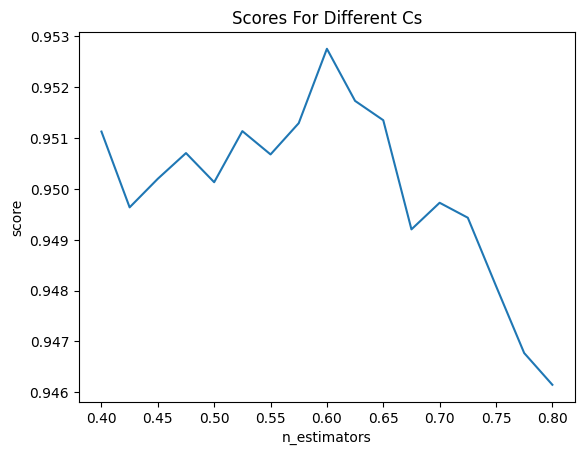

In [81]:
# Plot the scores.
plt.plot(df_scores.C, df_scores.score)
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.title('Scores For Different Cs')
plt.show()

In [82]:
# Get the maximum score.
max_score = df_scores.score.max()
print(f'max_score = {round(max_score, 4)}')

max_score = 0.9528


In [83]:
# Get the index of the maximum score .
index = df_scores.index[df_scores.score==max_score].tolist()[0]
print(f'index = {index}')

index = 8


In [84]:
# Find the C at the index.
max_C = df_scores.C[index]
print(f'max_C = {max_C}')

max_C = 0.6


### Random Forest Classifier

#### For n_estimators

In [85]:
# Copy the data to be used.
df = de.copy()

In [86]:
# Split the data.
_, _, X_train, X_val, _, _, y_train, y_val, _ = split_data(df)

In [87]:
# Find the best maximum n_estimators.
scores = []

for n in tqdm(range(100, 201, 20)):
    rfc = RandomForestClassifier(n_estimators=n, random_state=22, n_jobs=-1)
    rfc.fit(X_train, y_train)

    y_pred = rfc.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'score'])

  0%|          | 0/6 [00:00<?, ?it/s]

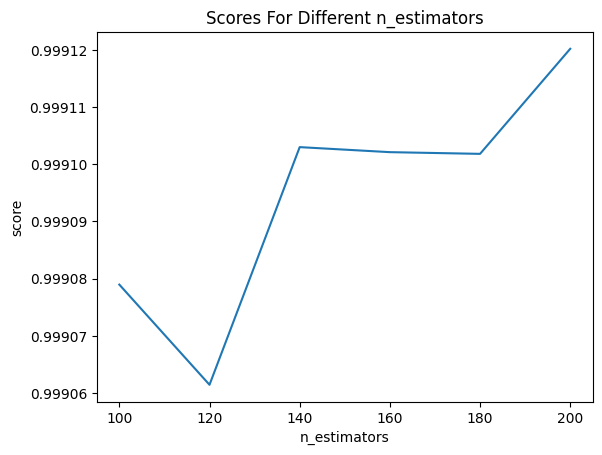

In [88]:
# Plot the scores.
plt.plot(df_scores.n_estimators, df_scores.score)
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.title('Scores For Different n_estimators')
plt.show()

In [89]:
# Get the maximum score.
max_score = df_scores.score.max()
print(f'max_score = {round(max_score, 4)}')

max_score = 0.9991


In [90]:
# Get the index of the maximum score.
index = df_scores.index[df_scores.score==max_score].tolist()[0]
print(f'index = {index}')

index = 5


In [91]:
# Find the n at the index.
max_n = df_scores.n_estimators[index]
print(f'max_n = {max_n}')

max_n = 200


#### For max_depth

In [92]:
# Copy the data to be used.
df = de.copy()

In [93]:
# Split the data.
_, _, X_train, X_val, _, _, y_train, y_val, _ = split_data(df)

In [94]:
# Find the best maximum depth.
scores = []

for d in tqdm([2, 4, 6, 8]):
    rfc = RandomForestClassifier(n_estimators=0,
                               max_depth=d,
                               random_state=22, 
                               n_jobs=-1)

    for n in tqdm(range(100, 201, 25)):
        rfc.n_estimators = n
        rfc.fit(X_train, y_train)

        y_pred = rfc.predict_proba(X_val)[:, 1]
        score = roc_auc_score(y_val, y_pred)

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'score']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

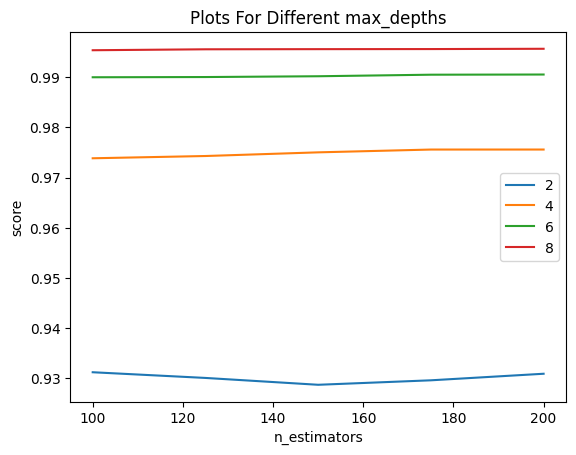

In [95]:
# Plot the scores.
for d in [2, 4, 6, 8]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.score, label=d)

plt.xlabel('n_estimators')
plt.ylabel('score')
plt.title('Plots For Different max_depths')
plt.legend()
plt.show()

In [96]:
# Get the maximum score.
max_score = df_scores.score.max()
print(f'max_score = {round(max_score, 4)}')

max_score = 0.9957


In [97]:
# Get the index of the maximum score.
index = df_scores.index[df_scores.score==max_score].tolist()[0]
print(f'index = {index}')

index = 19


In [98]:
# Find the d at the index.
max_d = df_scores.max_depth[index]
print(f'max_d = {max_d}')

max_d = 8


In [99]:
# Find the n at the index.
max_n = df_scores.n_estimators[index]
print(f'max_n = {max_n}')

max_n = 200


### Gradient Boosting Classifier

#### For n_estimators

In [100]:
# Copy the data to be used.
df = de.copy()

In [101]:
# Split the data.
_, _, X_train, X_val, _, _, y_train, y_val, _ = split_data(df)

In [102]:
# Find the best maximum n_estimators.
scores = []

for n in tqdm(range(100, 201, 20)):
    gbc = GradientBoostingClassifier(n_estimators=n, random_state=22)
    gbc.fit(X_train, y_train)
    
    y_pred = gbc.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, y_pred)
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'score'])

  0%|          | 0/6 [00:00<?, ?it/s]

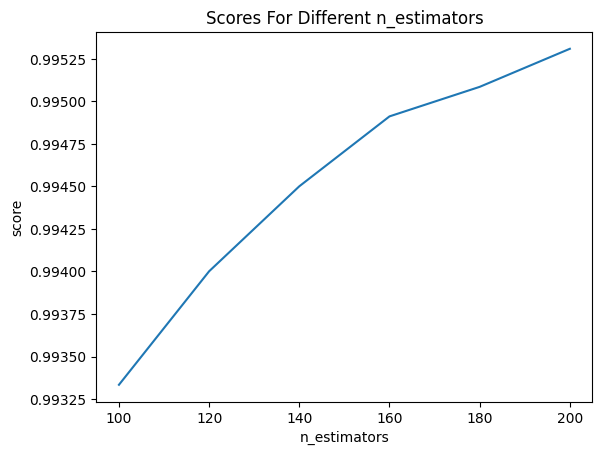

In [103]:
# Plot the scores.
plt.plot(df_scores.n_estimators, df_scores.score)
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.title('Scores For Different n_estimators')
plt.show()

In [104]:
# Get the maximum score.
max_score = df_scores.score.max()
print(f'max_score = {round(max_score, 4)}')

max_score = 0.9953


In [105]:
# Get the index of the maximum score.
index = df_scores.index[df_scores.score==max_score].tolist()[0]
print(f'index = {index}')

index = 5


In [106]:
# Find the n at the index.
max_n = df_scores.n_estimators[index]
print(f'max_n = {max_n}')

max_n = 200


#### For learning_rate

In [107]:
# Copy the data to be used.
df = de.copy()

In [108]:
# Split the data.
_, _, X_train, X_val, _, _, y_train, y_val, _ = split_data(df)

In [109]:
# Find the best learning rate.
scores = []

for l in tqdm([0.1, 0.2, 0.3]):
    gbc = GradientBoostingClassifier(n_estimators=0, learning_rate=l, random_state=22)

    for n in tqdm(range(100, 201, 20)):
        gbc.n_estimators = n
        gbc.fit(X_train, y_train)

        y_pred = gbc.predict_proba(X_val)[:, 1]
        score = roc_auc_score(y_val, y_pred)

        scores.append((l, n, score))

columns = ['learning_rate', 'n_estimators', 'score']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

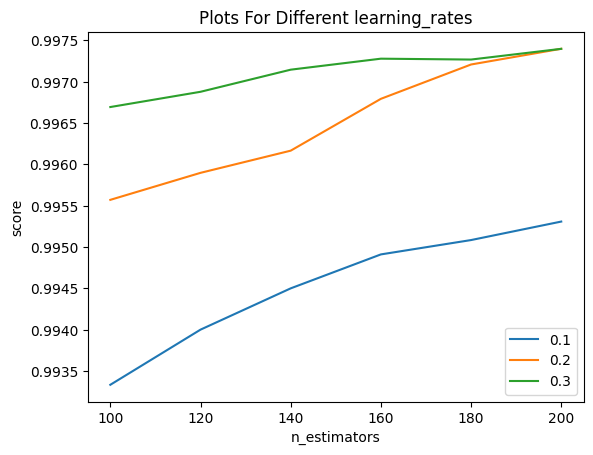

In [110]:
# Plot the scores.
for l in [0.1, 0.2, 0.3]:
    df_subset = df_scores[df_scores.learning_rate == l]
    plt.plot(df_subset.n_estimators, df_subset.score, label=l)

plt.xlabel('n_estimators')
plt.ylabel('score')
plt.title('Plots For Different learning_rates')
plt.legend()
plt.show()

In [111]:
# Get the maximum score.
max_score = df_scores.score.max()
print(f'max_score = {round(max_score, 4)}')

max_score = 0.9974


In [112]:
# Get the index of the maximum score.
index = df_scores.index[df_scores.score==max_score].tolist()[0]
print(f'index = {index}')

index = 11


In [113]:
# Find the l at the index.
max_l = df_scores.learning_rate[index]
print(f'max_l = {max_l}')

max_l = 0.2


In [114]:
# Find the n at the index.
max_n = df_scores.n_estimators[index]
print(f'max_n = {max_n}')

max_n = 200


### XGB Classifier

In [115]:
# Copy the data to be used.
df = de.copy()

In [116]:
# Define a function to parse the output.
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    
    return df_results

In [117]:
# Get dtrain and dval.
dtrain, dval, _ = dicts_data(df)

In [118]:
# Initialize the process.
watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}

In [119]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [120]:
# Store values for 'eta=0.3'.
scores['eta=0.1'] = parse_xgb_output(output)

In [121]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [122]:
# Store values for 'eta=0.3'.
scores['eta=0.3'] = parse_xgb_output(output)

In [123]:
%%capture output

xgb_params = {
    'eta': 0.5, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [124]:
# Store values for 'eta=0.5'.
scores['eta=0.5'] = parse_xgb_output(output)

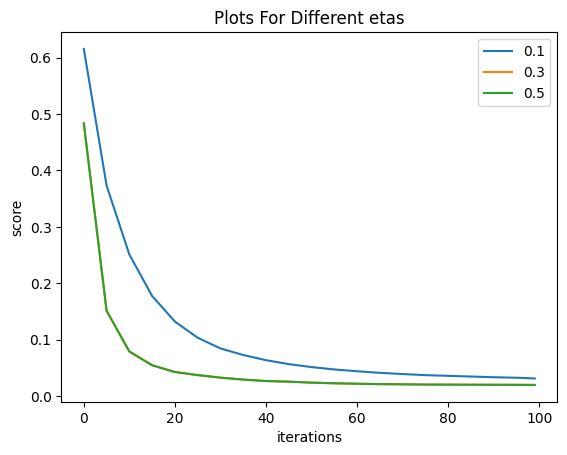

In [125]:
# Inspect the results.
plt.plot(scores['eta=0.1'].num_iter, scores['eta=0.1'].val_auc, label='0.1')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc, label='0.3')
plt.plot(scores['eta=0.5'].num_iter, scores['eta=0.3'].val_auc, label='0.5')
plt.xlabel('iterations')
plt.ylabel('score')
plt.title('Plots For Different etas')
plt.legend()
plt.show()

In [126]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 4,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [127]:
# Store values for 'max_depth=4'.
scores['max_depth=4'] = parse_xgb_output(output)

In [128]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 8,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [129]:
# Store values for 'max_depth=8'.
scores['max_depth=8'] = parse_xgb_output(output)

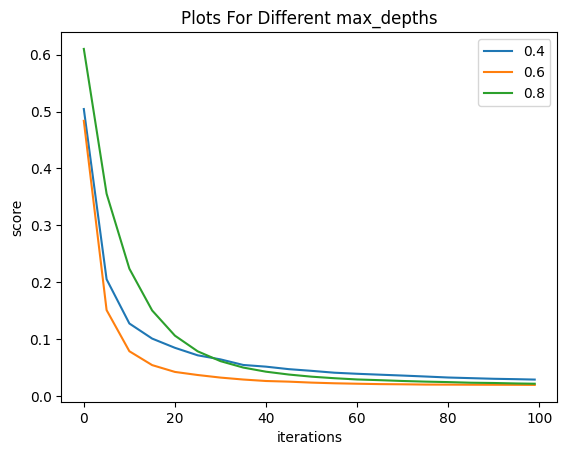

In [130]:
# Inspect the results.
plt.plot(scores['max_depth=4'].num_iter, scores['max_depth=4'].val_auc, label='0.4')
plt.plot(scores['eta=0.3'].num_iter, scores['eta=0.3'].val_auc, label='0.6')
plt.plot(scores['max_depth=8'].num_iter, scores['max_depth=8'].val_auc, label='0.8')
plt.xlabel('iterations')
plt.ylabel('score')
plt.title('Plots For Different max_depths')
plt.legend()
plt.show()

## Final Models

### Logistic Regression Algorithm

In [131]:
# Time the final model.
start_1 = time.time()

df = de.copy()
alg_lra = LogisticRegression(solver='liblinear', C=0.5, max_iter=1000, random_state=22)
score_lra, y_val, y_pred, dv, model_lra = score_data(alg_lra)
print(f'score_lra = {round(score_lra, 4)}')

end_1 = time.time()
print(f'time_lra = {round(end_1 - start_1, 2)}')

score_lra = 0.9523
time_lra = 13.2


In [132]:
# Save the model to the medel folder.
pickle.dump(model_lra, gzip.open(mdf + 'model_lra_2.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [133]:
# Define ROC curve plot function.
def roc_curve_draw(y_val, y_pred):
    plt.figure(figsize=(5, 5))
    fpr, tpr, _ = roc_curve(y_val, y_pred)
    plt.plot(fpr, tpr, label='probability')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

    plt.title('ROC Curve')
    plt.legend()
    
    return plt.show()

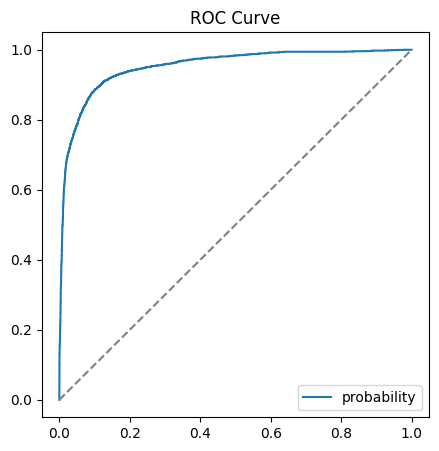

In [134]:
# Plot the ROC curve.
roc_curve_draw(y_val, y_pred)

In [135]:
# Define the confusion_matrix_dataframe function.
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

In [136]:
# Show the confusion matrix.
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,2151,17987,0,0
10,0.1,2035,4105,116,13882
20,0.2,1923,1973,228,16014
30,0.3,1738,1038,413,16949
40,0.4,1595,628,556,17359
50,0.5,1496,415,655,17572
60,0.6,1399,304,752,17683
70,0.7,1287,231,864,17756
80,0.8,1114,182,1037,17805
90,0.9,801,98,1350,17889


In [137]:
# Define the precision-recall plot function.
def pre_rec_plot(df_scores):
    # Calculate the precision and recall.
    df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)  
    
    # Plot the curves.
    plt.plot(df_scores.threshold, df_scores.p, label='precision')
    plt.plot(df_scores.threshold, df_scores.r, label='recall')

    plt.title('Precision-Recall Curves')
    plt.legend()
    
    return plt.show()

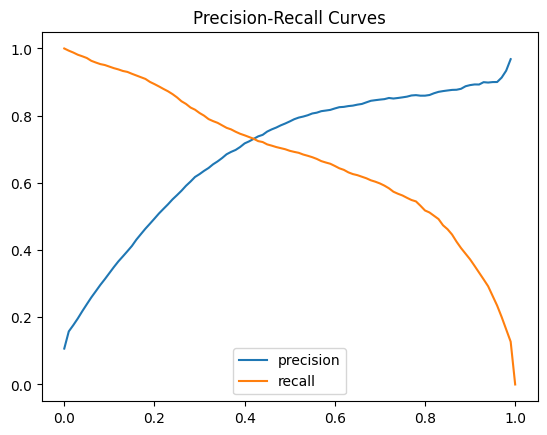

In [138]:
# Plot the precision and recall curves.
pre_rec_plot(df_scores)

In [139]:
# Get the F1 scores.
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

In [140]:
# Get the maximum f1-score.
f1_max_lr = df_scores['f1'].max()
print(f'f1_max_lr = {round(f1_max_lr, 4)}')

f1_max_lr = 0.7382


In [141]:
# Define the f1 plot function.
def f1_plot(df_scores):
    plt.plot(df_scores.threshold, df_scores.f1)
    plt.xticks(np.linspace(0, 1, 11))
    plt.title('F1 Curve')
    
    return plt.show()

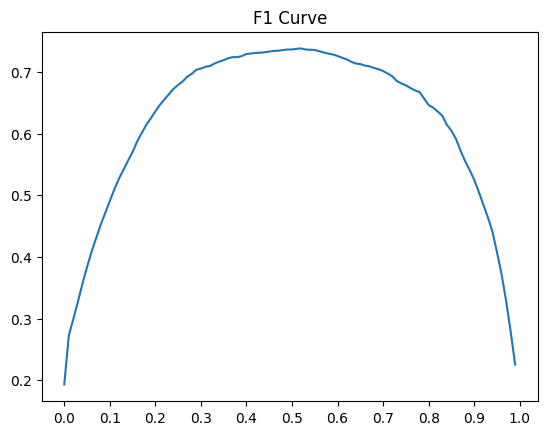

In [142]:
# Plot the F1 scores.
f1_plot(df_scores)

### Random Forest Classifier

In [143]:
# Time the final model.
start_2 = time.time()

df = de.copy()
alg_rfc = RandomForestClassifier(n_estimators=200, max_depth=8, random_state=22, n_jobs=-1)
score_rfc, y_val, y_pred, dv, model_rfc = score_data(alg_rfc)
print(f'score_rfc = {round(score_rfc, 4)}')

end_2 = time.time()
print(f'time_rfc = {round(end_2 - start_2, 2)}')

score_rfc = 0.9957
time_rfc = 49.55


In [144]:
# Save the model to the medel folder.
pickle.dump(model_rfc, gzip.open(mdf + 'model_rfc_2.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

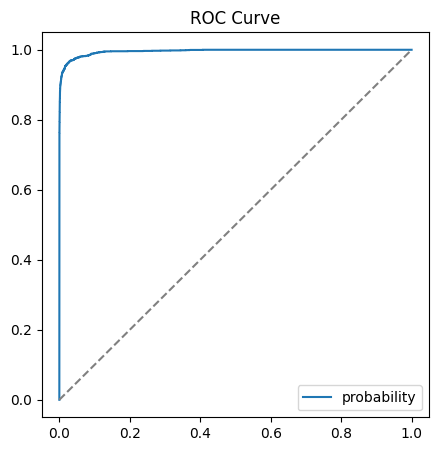

In [145]:
# Plot the ROC curve.
roc_curve_draw(y_val, y_pred)

In [146]:
# Show the confusion matrix.
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,2151,17987,0,0
10,0.1,2144,4703,7,13284
20,0.2,2130,1801,21,16186
30,0.3,2110,1108,41,16879
40,0.4,2086,641,65,17346
50,0.5,2055,337,96,17650
60,0.6,2001,134,150,17853
70,0.7,1897,37,254,17950
80,0.8,1713,12,438,17975
90,0.9,1413,2,738,17985


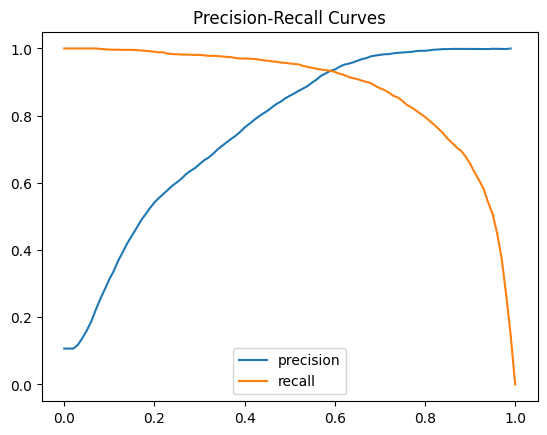

In [147]:
# Plot the precision and recall curves.
pre_rec_plot(df_scores)

In [148]:
# Get the F1 scores.
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

In [149]:
# Get the maximum f1-score.
f1_max_rf = df_scores['f1'].max()
print(f'f1_max_rf = {round(f1_max_rf, 4)}')

f1_max_rf = 0.9362


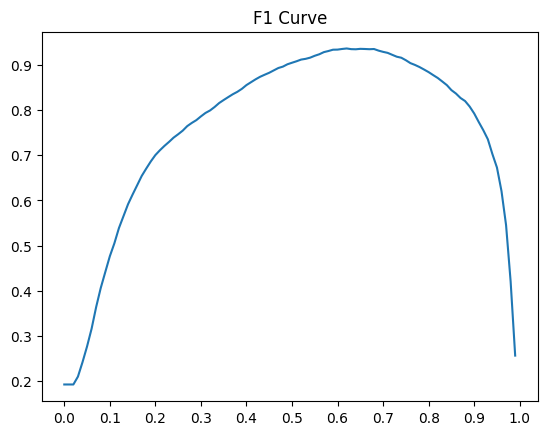

In [150]:
# Plot the F1 scores.
f1_plot(df_scores)

### Gradient Boosting Classifier

In [151]:
# Time the final model.
start_3 = time.time()

df = de.copy()
alg_gbc = GradientBoostingClassifier(n_estimators=100, random_state=22)
score_gbc, y_val, y_pred, model_gbc = score_data(alg_gbc)
print(f'score_gbc = {round(score_gbc, 4)}')

end_3 = time.time()
print(f'time_gbc = {round(end_3 - start_3, 2)}')

score_gbc = 0.9933
time_gbc = 157.27


In [152]:
# Save the model to the medel folder.
pickle.dump(model_gbc, gzip.open(mdf + 'model_gbc_2.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

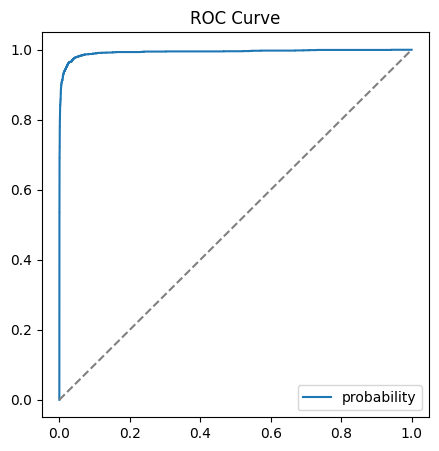

In [153]:
# Plot the ROC curve.
roc_curve_draw(y_val, y_pred)

In [154]:
# Show the confusion matrix.
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,2151,17987,0,0
10,0.1,2134,2572,17,15415
20,0.2,2123,1332,28,16655
30,0.3,2107,902,44,17085
40,0.4,2079,622,72,17365
50,0.5,2062,434,89,17553
60,0.6,2028,296,123,17691
70,0.7,1986,179,165,17808
80,0.8,1914,86,237,17901
90,0.9,1763,35,388,17952


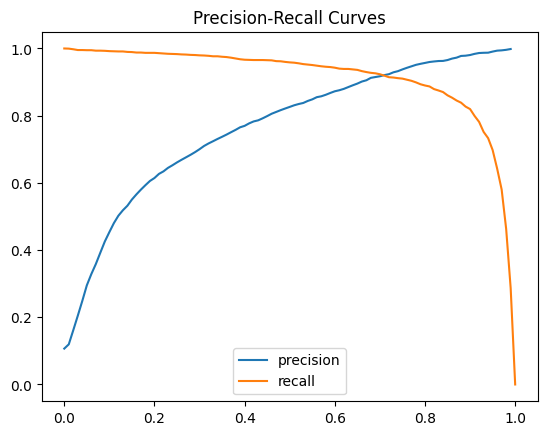

In [155]:
# Plot the precision and recall curves.
pre_rec_plot(df_scores)

In [156]:
# Get the F1 scores.
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

In [157]:
# Get the maximum f1-score.
f1_max_rf = df_scores['f1'].max()
print(f'f1_max_rf = {round(f1_max_rf, 4)}')

f1_max_rf = 0.9248


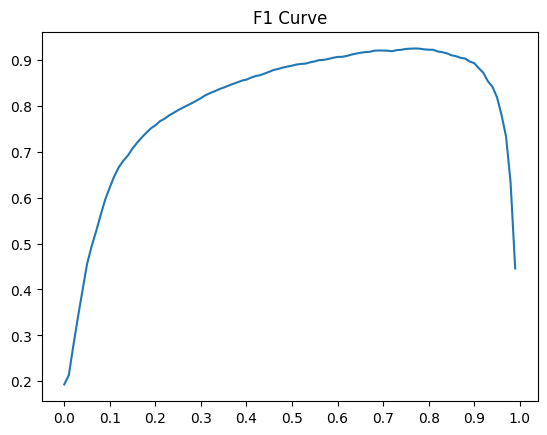

In [158]:
# Plot the F1 scores.
f1_plot(df_scores)

### XGB Classifier

In [159]:
# Time the final model.
start_4 = time.time()

df = de.copy()

xgb_params = {
    'eta': 0.3, 
    'max_depth': 8,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

score_xgb, y_val, y_pred, model_gbc = score_xdata(xgb_params)
print(f'score_xgb = {round(score_xgb, 4)}')

end_4 = time.time()
print(f'time_xgb = {round(end_4 - start_4, 2)}')

score_xgb = 0.997
time_xgb = 11.19


In [160]:
# Save the model to the medel folder.
pickle.dump(model_xgb, gzip.open(mdf + 'model_xgb_2.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

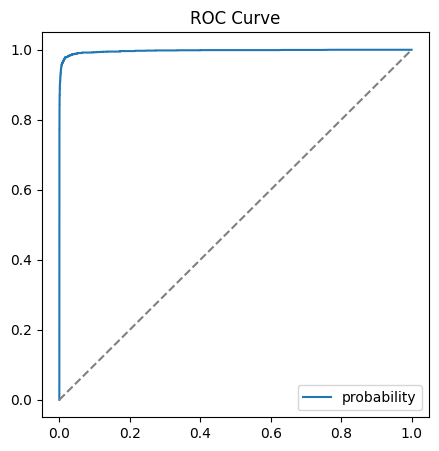

In [161]:
# Plot the ROC curve.
roc_curve_draw(y_val, y_pred)

In [162]:
# Show the confusion matrix.
df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,2151,17987,0,0
10,0.1,2132,1142,19,16845
20,0.2,2117,572,34,17415
30,0.3,2106,380,45,17607
40,0.4,2097,268,54,17719
50,0.5,2080,201,71,17786
60,0.6,2069,152,82,17835
70,0.7,2050,104,101,17883
80,0.8,2002,64,149,17923
90,0.9,1896,21,255,17966


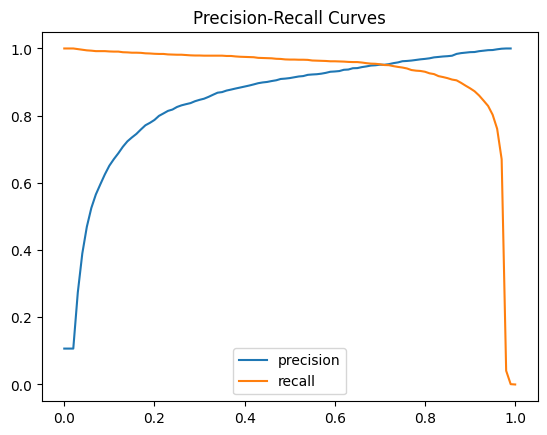

In [163]:
# Plot the precision and recall curves.
pre_rec_plot(df_scores)

In [164]:
# Get the F1 scores.
df_scores['f1'] = 2 * df_scores.p * df_scores.r / (df_scores.p + df_scores.r)

In [165]:
# Get the maximum f1-score.
f1_max_rf = df_scores['f1'].max()
print(f'f1_max_rf = {round(f1_max_rf, 4)}')

f1_max_rf = 0.9526


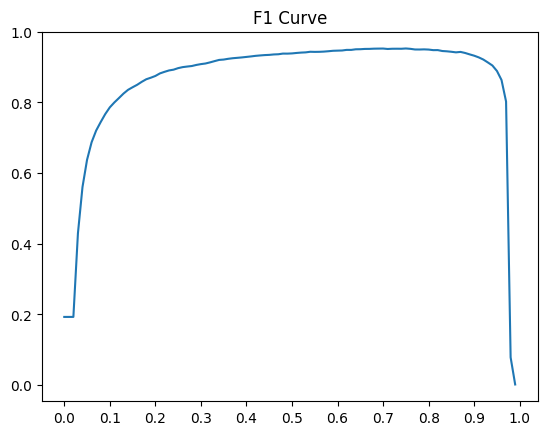

In [166]:
# Plot the F1 scores.
f1_plot(df_scores)

In [167]:
dr = pd.read_csv('../data/df_ari.csv')

In [ ]:
dv = DictVectorizer(sparse=False)

In [ ]:
# Define function to test model.
def test_model(df, model):
    

In [ ]:
# Create function to predict the raw data
def predict_data(raw_data):
    data_frame = pd.DataFrame(raw_data, index=[0])
    data_predict = loaded_model.predict(data_frame)
    return data_predict[0]

In [ ]:
# Get the sample data to use.
sample_data = df.loc[1404]
sample_data

In [ ]:
# Define raw data
raw_data = {
    "property_type": sample_data.loc['property_type'],
    "borough": sample_data.loc['borough'],
    "surface_covered_in_m2": sample_data.loc['surface_covered_in_m2'],
    "price_per_m2": sample_data.loc['price_per_m2'],
    "lat": sample_data.loc['lat'],
    "lon": sample_data.loc['lon']
}

raw_data

In [ ]:
# Compute prediction
prediction = predict_data(raw_data).round(2)
prediction